In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt, argparse, numpy as np, math, sys, copy
from skimage.segmentation import slic, mark_boundaries, felzenszwalb
from skimage.util import img_as_float
from scipy.cluster import hierarchy
from skimage import io
from collections import defaultdict
import numpy as np
import superpixels as sp
import plot as pl
import process_ground_truth as pgt
import glob
import eval_boundary as ev

In [3]:
ground_path = 'BSDS500/data/groundTruth/train/'
train_path = 'BSDS500/data/images/train/'

### Define parameters for process_image

Just run if you need to (it take a long time)

BSDS500/data/images/train/65132.jpg
Max precision:  0.252566915314
Max index:  1
Best slic:  896
Best felz: 1024


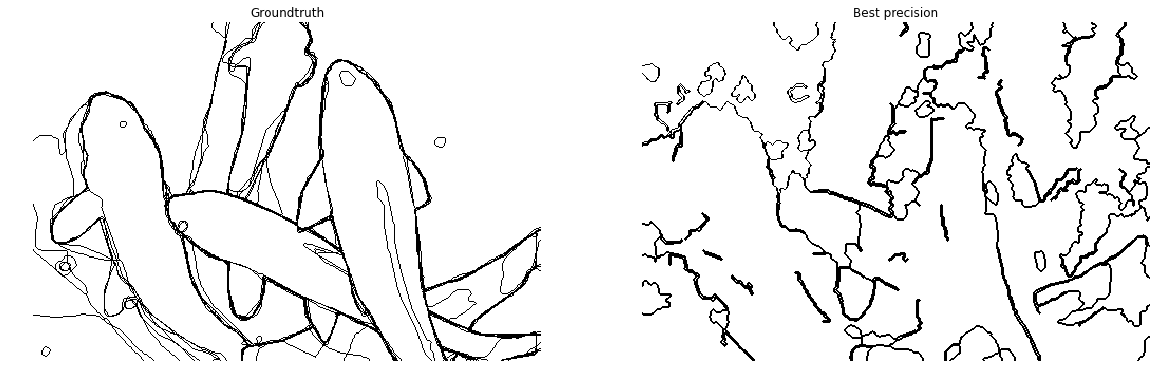

In [49]:
len_ground = len(ground_path)
ground_files = glob.glob(ground_path + '*.mat')
ground_filenames = [x[len_ground:-4] for x in ground_files]

index_filename = int(np.random.rand() * len_ground)

for filename in ground_filenames[index_filename-1:index_filename]:
    ground_file = ground_path + filename + '.mat'
    train_file = train_path + filename + '.jpg'
    
    groundtruth = pgt.get_groundTruth(ground_file)
    image = img_as_float(io.imread(train_file))
    
    best_precision, best_index = 0.0, 0.0
    best_slic, best_felz = 0, 0
    
    for slic_index in range(512, 1024, 128):
        for felz_index in range(1024, 2048, 128):
            _, fs_borders, fs_ultrametric = sp.process_image(image
                                                              , slic_segments = slic_index
                                                              , felz_scale = felz_index
                                                              , felz_min_size = 30
                                                              , save=False)

            len_ultra = len(fs_ultrametric)

            for i in range(len_ultra-1, 0, -1):       
                fs_ultra = fs_ultrametric[i][:, :, 0:1]
                precision, recall = ev.eval_bound(groundtruth, fs_ultra, 0)

                if precision > best_precision:
                    best_precision = precision
                    best_index = i
                    best_slic = slic_index
                    best_felz = felz_index

                    
    _, fs_borders, fs_ultrametric = sp.process_image(image
                                                      , slic_segments = best_slic
                                                      , felz_scale = best_felz
                                                      , felz_min_size = 30
                                                      , save=False)
                    
    print(train_file)
    print('Max precision: ', best_precision)
    print('Max index: ', best_index)
    print('Best slic: ', best_slic)
    print('Best felz:', best_felz)
    
    ground_image = np.zeros(image.shape,dtype=np.uint8)
    for i in range(0,3):
        ground_image[:, :, i] = groundtruth[:, :, 0]
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 20))
    ax1.imshow(ground_image)
    ax1.set_title("Groundtruth")
    ax1.set_axis_off()
    ax2.imshow(fs_ultrametric[best_index])
    ax2.set_title("Best precision")
    ax2.set_axis_off()
    plt.show() 

### Compare results with other methods

In [13]:
len_ground = len(ground_path)
ground_files = glob.glob(ground_path + '*.mat')
ground_filenames = [x[len_ground:-4] for x in ground_files]

images = []
groundtruths = []

#load images
for filename in ground_filenames[0:20]:
    ground_file = ground_path + filename + '.mat'
    train_file = train_path + filename + '.jpg'
    
    #read groundtruth and image
    groundtruth = pgt.get_groundTruth(ground_file)
    image = img_as_float(io.imread(train_file))
    
    #append image and groundtruths
    groundtruths.append(groundtruth)
    images.append(image)

In [27]:
img = np.zeros(image.shape,dtype=np.uint8) #create blank image to save
img.fill(255)

fs_borders, f_borders, s_borders = [], [], []

#test values for slic, felz and slic+felz
for groundtruth, image in zip(groundtruths[0:10], images[0:10]):
    #slic+felz
    _, fs_border, _ = sp.process_image(image
                                        , slic_segments = 896
                                        , felz_scale = 1024
                                        , felz_min_size = 30
                                        , ultrametric = False
                                        , save=False)
    
    img = np.zeros(image.shape,dtype=np.uint8) #create blank image to save
    img.fill(255)
    
    #felz
    f_segs = felzenszwalb(image, 1024, 30)
    f_border = mark_boundaries(img, f_segs, color=(0, 0, 0))
    
    #slic
    s_segs = slic(image, n_segments = 896, slic_zero = True)
    s_border = mark_boundaries(img, s_segs, color=(0, 0, 0))
    
    fs_borders.append(fs_border[:, :, 0:1])
    f_borders.append(f_border[:, :, 0:1])
    s_borders.append(s_border[:, :, 0:1])

In [31]:
fs_precs, f_precs, s_precs = [], [], []
fs_recall, f_recall, s_recall = [], [], []

threshold = 2

for groundtruth, fs_bor, f_bor, s_bor in zip(groundtruths[0:10], fs_borders, f_borders, s_borders):    
    #eval precision
    prec_fs, rec_fs = ev.eval_bound(groundtruth, fs_bor, threshold, True)
    prec_f, rec_f = ev.eval_bound(groundtruth, f_bor, threshold, True)
    prec_s, rec_s = ev.eval_bound(groundtruth, s_bor, threshold, True)
    
    #append results
    fs_precs.append(prec_fs)
    f_precs.append(prec_f)
    s_precs.append(prec_s)
    
    fs_recall.append(rec_fs)
    f_recall.append(rec_f)
    s_recall.append(rec_s)

In [32]:
print('Precision')
print('slic+felz >>', 'max:', np.max(fs_precs), ' avg:', np.average(fs_precs))
print('felz >>', 'max:', np.max(f_precs), ' avg:', np.average(f_precs))
print('slic >>', 'max:', np.max(s_precs), ' avg:', np.average(s_precs))

print('Recall')
print('slic+felz >>', 'max:', np.max(fs_recall), ' avg:', np.average(fs_recall))
print('felz >>', 'max:', np.max(f_recall), ' avg:', np.average(f_recall))
print('slic >>', 'max:', np.max(s_recall), ' avg:', np.average(s_recall))

Precision
slic+felz >> max: 0.868654311039  avg: 0.672991506719
felz >> max: 0.0166248955723  avg: 0.00166248955723
slic >> max: 0.948174467042  avg: 0.892766043575
Recall
slic+felz >> max: 0.754354156365  avg: 0.571602878938
felz >> max: 0.327935222672  avg: 0.0327935222672
slic >> max: 0.308062174192  avg: 0.198648627021
